In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from new_distance import *
%load_ext autoreload
%autoreload 2

Considering the possible effects connected to LC50. We need to filter on **Mortality Group**

## Preprocessing on base_db

In [3]:
base_db = pd.read_csv('output/base_db_smiles.csv')

In [4]:
to_drop = base_db[base_db.bonds_number.isnull()].index

In [5]:
base_db = base_db.drop(to_drop,axis=0)

In [6]:
base_db.columns

Index(['test_cas', 'exposure_type', 'obs_duration_mean', 'conc1_type',
       'conc1_mean', 'class', 'tax_order', 'family', 'genus', 'species',
       'organism_lifestage', 'organism_characteristics', 'ecotox_group',
       'smiles', 'atom_number', 'alone_atom_number', 'tripleBond',
       'doubleBond', 'bonds_number', 'ring_numer', 'Mol', 'MorganDensity',
       'LogP'],
      dtype='object')

In [7]:
use_db = base_db.copy()
use_db = use_db[['test_cas', 'exposure_type', 'obs_duration_mean', 'conc1_type',
       'conc1_mean', 'class', 'tax_order', 'family', 'genus', 'species','atom_number', 'alone_atom_number', 'tripleBond',
       'doubleBond', 'bonds_number', 'ring_numer',
       'Mol', 'MorganDensity', 'LogP']]

In [8]:
use_db.describe()

,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
count,53180.000000,5.318000e+04,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000
mean,62.448187,3.457718e+02,9.655773,1.584637,0.047461,1.230782,13.224878,1.097499,244.474903,1.071260,1.278474
std,41.799142,6.721350e+03,7.798505,2.144492,0.237127,1.258011,10.412063,1.358434,132.967880,0.323409,3.678951
min,0.125000,5.200000e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.012000,0.200000,-24.338100
25%,24.000000,1.790000e-01,5.000000,0.000000,0.000000,0.000000,4.000000,0.000000,159.609000,0.842105,-0.784780
50%,48.000000,2.200000e+00,8.000000,1.000000,0.000000,1.000000,13.000000,1.000000,228.679000,1.111111,2.121800
75%,96.000000,2.230000e+01,13.000000,3.000000,0.000000,2.000000,19.000000,2.000000,326.437000,1.272727,3.689800
max,964.000000,9.860000e+05,157.000000,45.000000,6.000000,18.000000,135.000000,14.000000,1736.185000,2.000000,13.789100


### obs_duration_mean/conc1_mean

In [9]:
# logarithmic transformations
use_db.obs_duration_mean = use_db.obs_duration_mean.apply(lambda x: np.log1p(x))
#use_db.conc1_mean = use_db.conc1_mean.apply(lambda x: np.log1p(x)) #Not good result

In [10]:
# MinMax scale
minmax = MinMaxScaler()
minmax.fit(use_db[["obs_duration_mean"]])
use_db[["obs_duration_mean"]] = minmax.transform(use_db[["obs_duration_mean"]])

In [11]:
use_db.describe()

,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
count,53180.000000,5.318000e+04,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000
mean,0.555602,3.457718e+02,9.655773,1.584637,0.047461,1.230782,13.224878,1.097499,244.474903,1.071260,1.278474
std,0.130311,6.721350e+03,7.798505,2.144492,0.237127,1.258011,10.412063,1.358434,132.967880,0.323409,3.678951
min,0.000000,5.200000e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.012000,0.200000,-24.338100
25%,0.459126,1.790000e-01,5.000000,0.000000,0.000000,0.000000,4.000000,0.000000,159.609000,0.842105,-0.784780
50%,0.558757,2.200000e+00,8.000000,1.000000,0.000000,1.000000,13.000000,1.000000,228.679000,1.111111,2.121800
75%,0.659861,2.230000e+01,13.000000,3.000000,0.000000,2.000000,19.000000,2.000000,326.437000,1.272727,3.689800
max,1.000000,9.860000e+05,157.000000,45.000000,6.000000,18.000000,135.000000,14.000000,1736.185000,2.000000,13.789100


In [12]:
# standardization
scaler = StandardScaler()
scaler.fit(use_db[["obs_duration_mean"]])
use_db[["obs_duration_mean"]] = scaler.transform(use_db[["obs_duration_mean"]])

## Atom Number

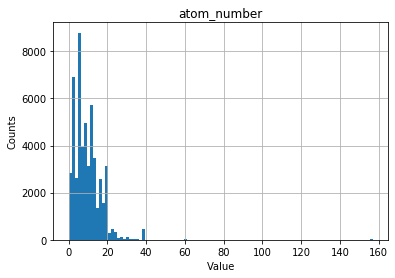

In [13]:
# plotted as before
use_db.atom_number.hist(bins=100)
plt.title("atom_number")
plt.xlabel("Value")
plt.ylabel("Counts");

We decided to scale by both a logarithmic transformations ans a MinMax scale

In [14]:
# logarithmic transformations
use_db.atom_number = use_db.atom_number.apply(lambda x: np.log1p(x))
# MinMax scale
minmax = MinMaxScaler()
minmax.fit(use_db[["atom_number"]])
use_db[["atom_number"]] = minmax.transform(use_db[["atom_number"]])

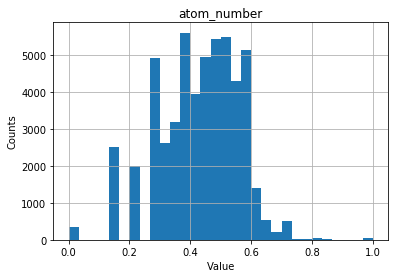

In [15]:
# plotted as before
use_db.atom_number.hist(bins=30)
plt.title("atom_number")
plt.xlabel("Value")
plt.ylabel("Counts");

## alone_Atom Number

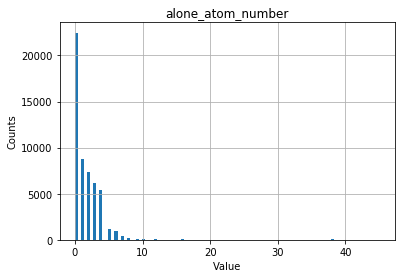

In [16]:
# plotted as before
use_db.alone_atom_number.hist(bins=100)
plt.title("alone_atom_number")
plt.xlabel("Value")
plt.ylabel("Counts");

## Bonds Number

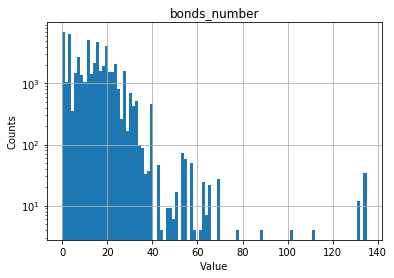

In [17]:
# plotted as before
use_db.bonds_number.hist(bins=100)
plt.yscale("log")
plt.title("bonds_number")
plt.xlabel("Value")
plt.ylabel("Counts");

We decided to scale by both a logarithmic transformations ans a MinMax scale

In [18]:
# logarithmic transformations
use_db.bonds_number = use_db.bonds_number.apply(lambda x: np.log1p(x))
# MinMax scale
minmax = MinMaxScaler()
minmax.fit(use_db[["bonds_number"]])
use_db[["bonds_number"]] = minmax.transform(use_db[["bonds_number"]])

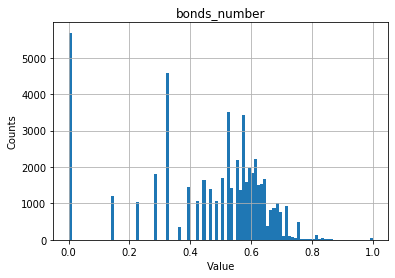

In [19]:
use_db.bonds_number.hist(bins=100)
plt.title("bonds_number")
plt.xlabel("Value")
plt.ylabel("Counts");

## tripleBond

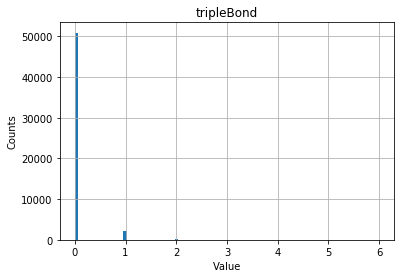

In [20]:
# plotted as before
use_db.tripleBond.hist(bins=100)
plt.title("tripleBond")
plt.xlabel("Value")
plt.ylabel("Counts");

## doubleBond

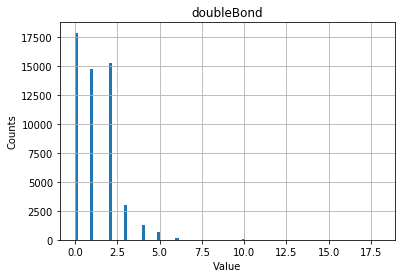

In [21]:
# plotted as before
use_db.doubleBond.hist(bins=100)
plt.title("doubleBond")
plt.xlabel("Value")
plt.ylabel("Counts");

## Rings number

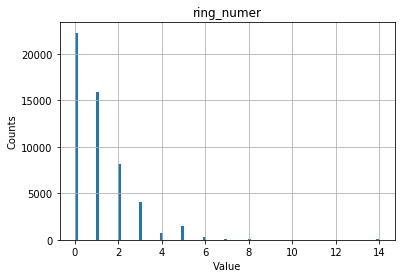

In [22]:
# plotted as before
use_db.ring_numer.hist(bins=100)
#plt.yscale("log")
plt.title("ring_numer")
plt.xlabel("Value")
plt.ylabel("Counts");

We assume this as a categrical features and we don't change it

## Mol

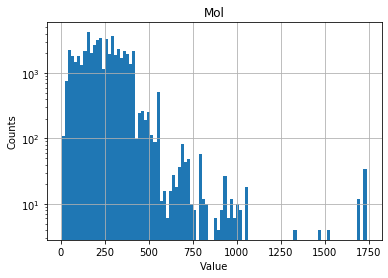

In [23]:
# plotted as before
use_db.Mol.hist(bins=100)
plt.yscale("log")
plt.title("Mol")
plt.xlabel("Value")
plt.ylabel("Counts");

We only this to scale the range of this variable

In [24]:
# MinMax scale
minmax = MinMaxScaler()
minmax.fit(use_db[["Mol"]])
use_db[["Mol"]] = minmax.transform(use_db[["Mol"]])

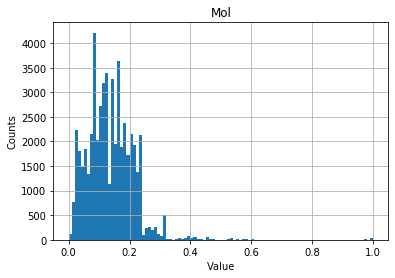

In [25]:
# plotted as before
use_db.Mol.hist(bins=100)
plt.title("Mol")
plt.xlabel("Value")
plt.ylabel("Counts");

## Morgan Density

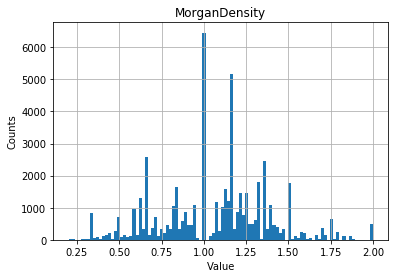

In [26]:
# plotted as before
use_db.MorganDensity.hist(bins=100)
#plt.yscale("log")
plt.title("MorganDensity")
plt.xlabel("Value")
plt.ylabel("Counts");

We keeo this untouch

## LogP

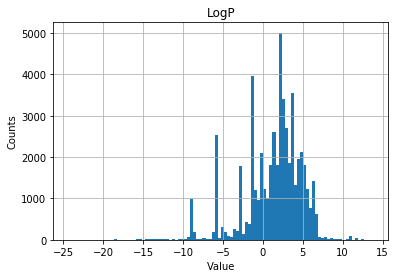

In [27]:
# plotted as before
use_db.LogP.hist(bins=100)
plt.title("LogP")
plt.xlabel("Value")
plt.ylabel("Counts");

### categorical features  
We will need to encode exposure_type, conc1_type, class, tax_order, family_genus, species. Not done now because we will encoding depending on the case

### Simple classification with Smile Features
Considering a threshold of 1mg/L of mortality

In [28]:
X = use_db.copy()
X = X[[
 'exposure_type',
 'obs_duration_mean',
 'conc1_type',
 'species',
 'atom_number', 
    'alone_atom_number', 
    'tripleBond',
       'doubleBond',
 'bonds_number',
  'ring_numer',
  'Mol', 
  'MorganDensity', 'LogP']]

In [29]:
X['exposure_type'].unique()

array(['S', 'F', 'R', 'AQUA', 'P', 'IP', 'E', 'SP', 'O', 'FD'],
      dtype=object)

In [30]:
X['conc1_type'].unique()

array(['T', 'D', 'L', 'F', 'A', 'U'], dtype=object)

In [31]:
len(X['species'].unique())

488

For this  vaiables we decided to transform than by an OrdinalEncoder, in order to have all numnerical variables

In [32]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X[["exposure_type", "conc1_type","species"]])
X[["exposure_type", "conc1_type","species"]] = enc.transform(X[["exposure_type", "conc1_type","species"]]) + 1

In [33]:
X.head()

,exposure_type,obs_duration_mean,conc1_type,species,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
0,9,0.024211,5,40,0.273831,3,0,0,0.0,0.0,0.10092,0.666667,-5.9945
1,9,-0.740360,5,208,0.273831,3,0,0,0.0,0.0,0.10092,0.666667,-5.9945
2,3,0.800083,5,312,0.273831,3,0,0,0.0,0.0,0.10092,0.666667,-5.9945
3,9,0.800083,5,474,0.273831,3,0,0,0.0,0.0,0.10092,0.666667,-5.9945
4,3,3.037407,5,312,0.273831,3,0,0,0.0,0.0,0.10092,0.666667,-5.9945


We also devide the label, in order to have a binary classification

In [34]:
y = base_db["conc1_mean"].copy().values
y = np.where(y > 1, 1, 0)

In [35]:
print(len(y[y==0]), len(y[y==1]))

22224 30956


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## KNN

We first implement a classification by a K Neighbors Classifier

In [37]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train.ravel())
y_pred = neigh.predict(X_test)

In [38]:
accuracy_score(y_test, y_pred)

0.8514529914529915

0.84 is the accuracy on tis first model

## Random Forest

In [39]:
forest = RandomForestClassifier(n_estimators = 100)
forest.fit(X_train, y_train.ravel())
y_pred = forest.predict(X_test)

In [40]:
accuracy_score(y_test, y_pred)

0.9129344729344729

This is the second model we have implemented, with an accurancy of the 0.91. which for the moment is not bad

## Gradient Boosting

In [41]:
grboost = GradientBoostingClassifier()
grboost.fit(X_train, y_train.ravel())
y_pred = grboost.predict(X_test)

In [42]:
accuracy_score(y_test, y_pred)

0.8331623931623932

In [43]:
# grid = GridSearchCV(forest, param_grid={"n_estimators": list(range(1, 500))}, scoring="accuracy", cv=5)
# grid.fit(X_train, y_train.ravel())

## bozza, NON RUNNARE!!!

In [44]:
df = pd.DataFrame(columns = X.columns, index=['KNN','Random Forest','Gradient Boosting'])

In [45]:
for i in X.columns:
    new_train = X_train.copy()
    new_test = X_test.copy()
    del new_train[i]
    del new_test[i]
    l=[]
    neigh = KNeighborsClassifier()
    neigh.fit(new_train, y_train.ravel())
    y_pred = neigh.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    forest = RandomForestClassifier(n_estimators = 100)
    forest.fit(new_train, y_train.ravel())
    y_pred = forest.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    grboost = GradientBoostingClassifier()
    grboost.fit(new_train, y_train.ravel())
    y_pred = grboost.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    df[i] = l

KeyboardInterrupt: 

## How doea the accurancy change without the column-variale?


In [54]:
corr = X.corr()
corr = corr.round(2)
corr.style.background_gradient(cmap='coolwarm')

,exposure_type,obs_duration_mean,conc1_type,species,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
exposure_type,1,-0.06,-0.13,-0,0.16,0.02,-0.04,0.09,0.16,0.09,0.13,0.03,0.07
obs_duration_mean,-0.06,1,0.01,0.02,-0.01,0.01,0.03,0,-0.06,-0.04,-0.02,-0,-0.05
conc1_type,-0.13,0.01,1,-0.09,-0.41,0.35,-0.02,-0.1,-0.68,-0.38,-0.36,-0.06,-0.59
species,-0,0.02,-0.09,1,-0.01,-0.01,-0.01,0,0.03,0.01,-0.01,0.01,0.02
atom_number,0.16,-0.01,-0.41,-0.01,1,0.17,0.03,0.6,0.74,0.43,0.76,-0.02,0.38
alone_atom_number,0.02,0.01,0.35,-0.01,0.17,1,-0.06,0.48,-0.11,-0,0.25,-0.12,-0.48
tripleBond,-0.04,0.03,-0.02,-0.01,0.03,-0.06,1,-0.07,0.04,0.05,0.03,0.09,0.07
doubleBond,0.09,0,-0.1,0,0.6,0.48,-0.07,1,0.42,0.24,0.51,0.13,-0.01
bonds_number,0.16,-0.06,-0.68,0.03,0.74,-0.11,0.04,0.42,1,0.64,0.72,-0.03,0.68
ring_numer,0.09,-0.04,-0.38,0.01,0.43,-0,0.05,0.24,0.64,1,0.69,-0.26,0.49


In [45]:
df

,exposure_type,obs_duration_mean,conc1_type,species,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
KNN,0.855328,0.857037,0.851339,0.859259,0.851966,0.848148,0.850484,0.845641,0.851624,0.850313,0.849174,0.849573,0.829231
Random Forest,0.906610,0.913903,0.910655,0.884217,0.912593,0.913390,0.913105,0.912650,0.911681,0.912536,0.901311,0.912308,0.911396
Gradient Boosting,0.829972,0.830085,0.826154,0.831054,0.831510,0.830085,0.829972,0.827578,0.828604,0.828547,0.812194,0.831966,0.817436


In [68]:
df1 = pd.DataFrame(columns = X.columns, index=['KNN','Random Forest','Gradient Boosting'])

In [59]:
new_train = X_train.copy()
new_test = X_test.copy()
for i in X.columns:
    
    l=[]
    neigh = KNeighborsClassifier()
    neigh.fit(new_train, y_train.ravel())
    y_pred = neigh.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    forest = RandomForestClassifier(n_estimators = 100)
    forest.fit(new_train, y_train.ravel())
    y_pred = forest.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    grboost = GradientBoostingClassifier()
    grboost.fit(new_train, y_train.ravel())
    y_pred = grboost.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    df1[i] = l
    del new_train[i]
    del new_test[i]    
    

In [73]:

for i in range(1,len(X.columns)):
    col = list(X.columns[:i])
    l=[]
    new_train = X_train[col]
    new_test = X_test[col]
    
    neigh = KNeighborsClassifier()
    neigh.fit(new_train, y_train.ravel())
    y_pred = neigh.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    forest = RandomForestClassifier(n_estimators = 100)
    forest.fit(new_train, y_train.ravel())
    y_pred = forest.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    grboost = GradientBoostingClassifier()
    grboost.fit(new_train, y_train.ravel())
    y_pred = grboost.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    df1[X.columns[i]] = l 

In [74]:
df1

,exposure_type,obs_duration_mean,conc1_type,species,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
KNN,NaN,0.440627,0.497208,0.573048,0.657037,0.744444,0.764729,0.771624,0.796467,0.803305,0.820513,0.824957,0.829231
Random Forest,NaN,0.586838,0.603305,0.623476,0.685698,0.772422,0.810085,0.819772,0.853732,0.883875,0.883989,0.910826,0.912137
Gradient Boosting,NaN,0.586838,0.601481,0.616695,0.634587,0.702051,0.708262,0.712934,0.740855,0.773675,0.778860,0.814473,0.817436


## KNN

In [91]:
import itertools
to_compare = list(itertools.combinations(list(X_train.columns), 2))

In [92]:
df2 = pd.DataFrame(columns = ['Accurancy'], index=to_compare)

In [93]:
for i in df2.index:
    
    new_train = X_train[list(i)]
    new_test = X_test[list(i)]
    
    neigh = KNeighborsClassifier()
    neigh.fit(new_train, y_train.ravel())
    y_pred = neigh.predict(new_test)
    df2['Accurancy'].loc[i] = accuracy_score(y_test, y_pred)

In [68]:
df2.sort_values(by= ['Accurancy'],ascending=False).head(20)

,Accurancy
"(species, Mol)",0.849345
"(species, LogP)",0.849003
"(bonds_number, Mol)",0.847749
"(ring_numer, Mol)",0.846097
"(exposure_type, Mol)",0.842108
"(atom_number, Mol)",0.841368
"(tripleBond, Mol)",0.838746
"(conc1_type, Mol)",0.837436
"(doubleBond, Mol)",0.835783
"(Mol, LogP)",0.83208


## RANDOM FOREST

In [69]:
df3 = pd.DataFrame(columns = ['Accurancy_RF'], index=to_compare)

In [72]:
for i in df3.index:
    
    new_train = X_train[list(i)]
    new_test = X_test[list(i)]
    
    forest = RandomForestClassifier(n_estimators = 100)
    forest.fit(new_train, y_train.ravel())
    y_pred = forest.predict(new_test)
    df3['Accurancy_RF'].loc[i] = accuracy_score(y_test, y_pred)

In [74]:
df3.sort_values(by= ['Accurancy_RF'],ascending=False).head(20)

,Accurancy_RF
"(species, Mol)",0.890484
"(species, LogP)",0.882906
"(exposure_type, Mol)",0.869516
"(conc1_type, Mol)",0.862735
"(Mol, LogP)",0.861425
"(ring_numer, Mol)",0.860456
"(Mol, MorganDensity)",0.860228
"(bonds_number, Mol)",0.860171
"(atom_number, Mol)",0.860114
"(doubleBond, Mol)",0.859829


## GRADIENT BOOSTING

In [77]:
df4 = pd.DataFrame(columns = ['Accurancy_GB'], index=to_compare)

In [78]:
for i in df4.index:
    
    new_train = X_train[list(i)]
    new_test = X_test[list(i)]
    
    forest = RandomForestClassifier(n_estimators = 100)
    forest.fit(new_train, y_train.ravel())
    y_pred = forest.predict(new_test)
    df4['Accurancy_GB'].loc[i] = accuracy_score(y_test, y_pred)

In [105]:
tot = df4.rank()['Accurancy_GB'] + df3.rank()['Accurancy_RF'] + df2.rank()['Accurancy']
        

In [107]:
tot = pd.DataFrame(tot)

In [117]:
tot = tot.reset_index()

In [122]:
top_features= tot.explode('index').sort_values(by=[0],ascending=False).groupby('index').sum()

In [127]:
try_features= top_features.sort_values(by=[0],ascending=False).head(6).index

In [128]:
try_features

Index(['Mol', 'LogP', 'MorganDensity', 'bonds_number', 'atom_number',
       'species'],
      dtype='object', name='index')

In [129]:
    new_train = X_train[list(try_features)]
    new_test = X_test[list(try_features)]
    
    neigh = KNeighborsClassifier()
    neigh.fit(new_train, y_train.ravel())
    y_pred = neigh.predict(new_test)
    accuracy_score(y_test, y_pred)

0.8605698005698006

In [131]:
    forest = RandomForestClassifier(n_estimators = 100)
    forest.fit(new_train, y_train.ravel())
    y_pred = forest.predict(new_test)
    accuracy_score(y_test, y_pred)

0.9067806267806268

In [132]:
    forest = RandomForestClassifier(n_estimators = 100)
    forest.fit(new_train, y_train.ravel())
    y_pred = forest.predict(new_test)
    accuracy_score(y_test, y_pred)

0.9065527065527066

In [133]:
try_features = top_features.sort_values(by=[0],ascending=False).index

In [134]:
try_features

Index(['Mol', 'LogP', 'MorganDensity', 'bonds_number', 'atom_number',
       'species', 'ring_numer', 'doubleBond', 'alone_atom_number',
       'conc1_type', 'exposure_type', 'obs_duration_mean', 'tripleBond'],
      dtype='object', name='index')

In [136]:
top_features.sort_values(by=[0],ascending=False)

,0
index,
Mol,2571.0
LogP,2269.0
MorganDensity,1878.5
bonds_number,1654.5
atom_number,1441.0
species,1356.0
ring_numer,1301.0
doubleBond,1074.0
alone_atom_number,1050.0


In [138]:
df1 = pd.DataFrame(columns = try_features, index=['KNN','Random Forest','Gradient Boosting'])
for i in range(1,len(try_features)):
    col = list(try_features[:i])
    l=[]
    new_train = X_train[col]
    new_test = X_test[col]
    
    neigh = KNeighborsClassifier()
    neigh.fit(new_train, y_train.ravel())
    y_pred = neigh.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    forest = RandomForestClassifier(n_estimators = 100)
    forest.fit(new_train, y_train.ravel())
    y_pred = forest.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    grboost = GradientBoostingClassifier()
    grboost.fit(new_train, y_train.ravel())
    y_pred = grboost.predict(new_test)
    l.append(accuracy_score(y_test, y_pred))
    
    df1[X.columns[i]] = l 

In [139]:
df1

index,Mol,LogP,MorganDensity,bonds_number,atom_number,species,ring_numer,doubleBond,alone_atom_number,conc1_type,exposure_type,obs_duration_mean,tripleBond
KNN,0.862165,0.850427,0.856467,0.862336,0.838746,0.843989,0.866610,0.858462,0.843476,0.832080,NaN,0.813504,0.860570
Random Forest,0.907236,0.912308,0.913903,0.905527,0.862393,0.861937,0.905983,0.906382,0.862450,0.861425,NaN,0.859886,0.907692
Gradient Boosting,0.828718,0.829972,0.830484,0.828148,0.817493,0.814758,0.829117,0.825641,0.822165,0.805071,NaN,0.785242,0.826895


In [153]:
X

,exposure_type,obs_duration_mean,conc1_type,species,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
0,9,0.024211,5,40,0.273831,3,0,0,0.000000,0.0,0.100920,0.666667,-5.9945
1,9,-0.740360,5,208,0.273831,3,0,0,0.000000,0.0,0.100920,0.666667,-5.9945
2,3,0.800083,5,312,0.273831,3,0,0,0.000000,0.0,0.100920,0.666667,-5.9945
3,9,0.800083,5,474,0.273831,3,0,0,0.000000,0.0,0.100920,0.666667,-5.9945
4,3,3.037407,5,312,0.273831,3,0,0,0.000000,0.0,0.100920,0.666667,-5.9945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53647,3,0.800083,1,372,0.384370,0,0,0,0.522111,1.0,0.089879,1.166667,2.3901
53648,1,-0.571732,3,422,0.473649,0,0,2,0.576717,1.0,0.122888,1.437500,1.3211
53649,9,0.800083,1,262,0.490837,2,0,2,0.609799,2.0,0.162214,1.368421,0.8126
53650,3,0.800083,1,372,0.384370,0,0,2,0.522111,1.0,0.091541,1.083333,0.4780


## FROM HERE WE USE THE DISTANCE MATRIX

In [46]:
categorical = [
"exposure_type", 
"conc1_type","species",
'tripleBond']

In [47]:
non_categorical =[
 'obs_duration_mean',
 'atom_number',
 'alone_atom_number',
 'doubleBond',
 'bonds_number',
 'ring_numer',
 'Mol',
 'MorganDensity',
 'LogP']

In [48]:
from new_distance import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
X_try  =  X.head(1000)
y_try = y[:1000]

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_try, y_try, test_size=0.33, random_state=42)

In [ ]:
X_train_new, X_test_new = new_distance_matrix(X_train,X_test, categorical,non_categorical)

In [160]:
X_train_new.shape

In [162]:
X_test_new.shape

(330, 670)

In [163]:
neigh = KNeighborsClassifier(metric = 'precomputed')
neigh.fit(X_train_new, y_train.ravel())
y_pred = neigh.predict(X_test_new)

In [165]:
accuracy_score(y_test, y_pred)

0.803030303030303